In [135]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = r"C:\Users\narea\Desktop\Dataset"
def findFiles(path): return glob.glob(path)
#데이터 불러오기

In [136]:
# for reproducibility
#random.seed(777)
#torch.manual_seed(777)
#if device == 'cuda':
#    torch.cuda.manual_seed_all(777)

In [137]:
#하이퍼 파라미터 설정
training_epochs = 10
batch_size = 32

learning_rate = 0.001

input_size = 2500    # 300x300 image       # 고정된 값 (이미지 크기)
hidden_size = 1000   # 임의의 값           # 임의의 값 (hidden layer의 노드 개수)
output_size = 2    # OX               # 고정된 값 (분류할 클래스 개수)

In [138]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import cv2
import numpy as np
from matplotlib import pyplot as plt

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1+image_list2
transform = transforms.ToTensor()

#image = Image.open(image_list[0]).convert("L")
#image = transform(image)

dataset = []
labels = []

for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50,50))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0) #결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1) #결과 레이블 'x'

print(f"dataset 배열 크기 : {len(dataset)}")
print(f"첫번째 원소값 사이즈: {dataset[0].size()}")

dataset 배열 크기 : 280
첫번째 원소값 사이즈: torch.Size([1, 50, 50])


In [139]:
# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels)), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [140]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.sequential = nn.Sequential(
            nn.Flatten(),  # 50*50 이미지를 250*1 벡터로 변환
            nn.Linear(in_features=2500, out_features=1250, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1250, out_features=625, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=625, out_features=315, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=315, out_features=150, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=150, out_features=70, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=70, out_features=2, bias=True)
        )

    def forward(self, x):
        return self.sequential(x)

model = MLP()
criterion = nn.CrossEntropyLoss() #손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #옵티마이저

In [141]:
for epoch in range(100):
    avg_cost = 0
    total_batch = len(train_loader)
    
    for images, labels in train_loader:
        optimizer.zero_grad()

        hypothesis = model(images)

        cost = criterion(hypothesis, labels)
        cost.backward()
        
        optimizer.step()
        avg_cost += cost / total_batch

    print("Epoch:", "%04d" % (epoch + 1), "cost =", "{:.9f}".format(avg_cost))


Epoch: 0001 cost = 0.692518055
Epoch: 0002 cost = 0.691993654
Epoch: 0003 cost = 0.693644404
Epoch: 0004 cost = 0.692798793
Epoch: 0005 cost = 0.690797865
Epoch: 0006 cost = 0.689669430
Epoch: 0007 cost = 0.687965095
Epoch: 0008 cost = 0.683835864
Epoch: 0009 cost = 0.680390239
Epoch: 0010 cost = 0.679513931
Epoch: 0011 cost = 0.668823242
Epoch: 0012 cost = 0.663470984
Epoch: 0013 cost = 0.675972283
Epoch: 0014 cost = 0.653896034
Epoch: 0015 cost = 0.633952439
Epoch: 0016 cost = 0.607766926
Epoch: 0017 cost = 0.587713480
Epoch: 0018 cost = 0.551999688
Epoch: 0019 cost = 0.564672709
Epoch: 0020 cost = 0.574575007
Epoch: 0021 cost = 0.487604618
Epoch: 0022 cost = 0.535993278
Epoch: 0023 cost = 0.554799795
Epoch: 0024 cost = 0.543989956
Epoch: 0025 cost = 0.699336231
Epoch: 0026 cost = 0.528598011
Epoch: 0027 cost = 0.527323544
Epoch: 0028 cost = 0.507255137
Epoch: 0029 cost = 0.457502961
Epoch: 0030 cost = 0.457704663
Epoch: 0031 cost = 0.449349284
Epoch: 0032 cost = 0.467080981
Epoch: 0

Accuracy of the model on the test images: 82.14%
Label: 0
Prediction: 0


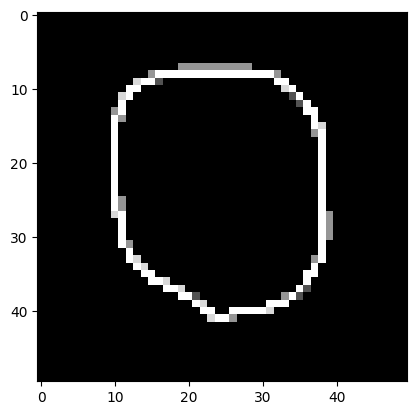

In [143]:
import random
import matplotlib.pyplot as plt

# 테스트 데이터를 사용하여 모델을 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():  # torch.no_grad()를 하면 gradient 계산을 수행하지 않음
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# 테스트 데이터에서 무작위로 하나를 뽑아서 예측
r = random.randint(0, len(test_dataset) - 1)
single_image, single_label = test_dataset[r]
single_image = single_image.unsqueeze(0)  # 배치 차원을 추가
with torch.no_grad():
    single_prediction = model(single_image)
    predicted_label = torch.argmax(single_prediction, 1).item()

print(f'Label: {single_label.item()}')
print(f'Prediction: {predicted_label}')

# 이미지 출력
plt.imshow(single_image.squeeze().numpy(), cmap="Greys", interpolation="nearest")
plt.show()


In [144]:
###여기서부터는 챗 gpt 코드. 

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1 + image_list2
transform = transforms.ToTensor()

# 이미지 데이터셋과 레이블 리스트 초기화
dataset = []
labels = []

for idx in image_list:
    # 이미지 읽기 및 전처리
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50, 50))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)
    
    # 파일 이름에서 레이블 추출 ('o' 또는 'x'가 파일 이름에 포함되어 있는 경우)
    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0)  # 결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1)  # 결과 레이블 'x'

print(f"dataset 배열 크기 : {len(dataset)}")
print(f"첫번째 원소값 사이즈: {dataset[0].size()}")

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

# CustomDataset 생성
full_dataset = CustomDataset(dataset, labels)

# 데이터셋 분할
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader 생성
batch_size = 320
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.sequential = nn.Sequential(
            nn.Flatten(),  # 50*50 이미지를 2500*1 벡터로 변환
            nn.Linear(in_features=2500, out_features=1000, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=500, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=100, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2, bias=True)
        )

    def forward(self, x):
        return self.sequential(x)

# Hyperparameters
training_epochs = 10
k_folds = 5
learning_rate = 0.001

# KFold 설정
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(full_dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    # DataLoader 생성
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=test_subsampler)
    
    # 모델 초기화
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # 모델 학습
    for epoch in range(100):
        model.train()
        total_loss = 0
        for (images, labels) in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{training_epochs}], Loss: {avg_loss:.4f}')
    
    # 모델 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on fold {fold+1}: {accuracy:.2f}%')
    
    # 결과 저장
    fold_results.append(accuracy)

# k-fold 결과 출력
print('--------------------------------')
print('K-FOLD CROSS VALIDATION RESULTS')
print('--------------------------------')
print(f'All fold results: {fold_results}')
print(f'Average accuracy: {sum(fold_results) / len(fold_results):.2f}%')


dataset 배열 크기 : 280
첫번째 원소값 사이즈: torch.Size([1, 50, 50])
FOLD 1
--------------------------------
Epoch [1/10], Loss: 0.6920
Epoch [2/10], Loss: 0.6891
Epoch [3/10], Loss: 0.6866
Epoch [4/10], Loss: 0.6844
Epoch [5/10], Loss: 0.6807
Epoch [6/10], Loss: 0.6784
Epoch [7/10], Loss: 0.6749
Epoch [8/10], Loss: 0.6722
Epoch [9/10], Loss: 0.6683
Epoch [10/10], Loss: 0.6646
Epoch [11/10], Loss: 0.6602
Epoch [12/10], Loss: 0.6558
Epoch [13/10], Loss: 0.6506
Epoch [14/10], Loss: 0.6450
Epoch [15/10], Loss: 0.6393
Epoch [16/10], Loss: 0.6327
Epoch [17/10], Loss: 0.6255
Epoch [18/10], Loss: 0.6180
Epoch [19/10], Loss: 0.6100
Epoch [20/10], Loss: 0.6021
Epoch [21/10], Loss: 0.5944
Epoch [22/10], Loss: 0.5872
Epoch [23/10], Loss: 0.5788
Epoch [24/10], Loss: 0.5692
Epoch [25/10], Loss: 0.5607
Epoch [26/10], Loss: 0.5540
Epoch [27/10], Loss: 0.5479
Epoch [28/10], Loss: 0.5395
Epoch [29/10], Loss: 0.5283
Epoch [30/10], Loss: 0.5211
Epoch [31/10], Loss: 0.5170
Epoch [32/10], Loss: 0.5107
Epoch [33/10], L